In [1]:
#Descargamos la base de datos
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv \
    -O /content/monthly-sunspots.csv

--2021-08-13 14:42:30--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45039 (44K) [text/plain]
Saving to: ‘/content/monthly-sunspots.csv’

/content/monthly-su 100%[===================>]  43.98K  --.-KB/s    in 0.006s  

2021-08-13 14:42:31 (6.81 MB/s) - ‘/content/monthly-sunspots.csv’ saved [45039/45039]



In [2]:
fname = '/content/monthly-sunspots.csv'  # El archivo esta en memoria virtual
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')           # Organizar la base de datos, despues de cada salto de linea tenemos una instancia.  
header = lines[0].split(',')       # Nos quedamos con la primera linea o encabezados
lines = lines[1:]                  # Despues de la primera linea ya son los datos

print(header)
print(len(lines))

['"Month"', '"Sunspots"']
2820


In [4]:
#La lista de manchas solares mensuales se convierte en un numpy array
import numpy as np

float_data = []
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data.append(values[0])

In [5]:
float_data = np.array(float_data)

In [6]:
float_data

array([58. , 62.6, 70. , ..., 55.8, 33.3, 33.4])

In [7]:
float_data.shape

(2820,)

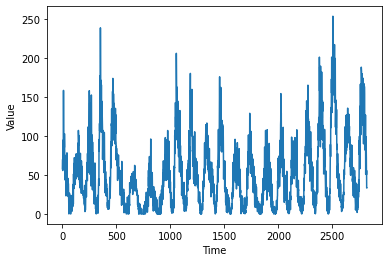

In [9]:
#Graficamos la serie de tiempo
from matplotlib import pyplot as plt

plt.plot(range(float_data.shape[0]), float_data)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [13]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback 
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size) 
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback 
            rows = np.arange(i, min(i + batch_size, max_index)) 
            i += len(rows)

        samples = np.zeros((len(rows), 
                           lookback // step))    # Solo se tienen dos dimensiones
        targets = np.zeros((len(rows),)) 
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step) 
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay] 
        samples = np.expand_dims(samples, -1)    # Agregamos una dimension extra, ya que se esperan 3 dimensiones para entrar a una capa convolucional de 1D
        yield samples, targets

In [23]:
lookback = 64       # Se toman 64 timesteps
step = 1            # No hay filtro, de uno por uno
delay = 1           # Se predice un mes despues
batch_size = 164

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=2200,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=2201,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

# This is how many steps to draw from `train_gen`
# in order to see the whole training set:
train_steps = (2200 - 0 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole validation set:
val_steps = (len(float_data) - 2201 - lookback) // batch_size

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(60, 5, activation='relu',           # Red convolucional, no pide poner el argumento del lote, lo dejamos None
                        input_shape=(None, 1)))
model.add(layers.MaxPooling1D(3))
model.add(layers.LSTM(60, return_sequences=True))           # Red recurrente profunda
model.add(layers.LSTM(60))
model.add(layers.Dense(30
                       , activation="relu"))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(1))
model.add(layers.Lambda(lambda x: x * 400))                 # Aplicar cualquier operacion en la arquitectura neuronal, se utiliza por que los resultados de la base de datos son altos, no estan entre [0,1]

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=100,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/100
13/13 [==============================] - 4s 65ms/step - loss: 18.4311 - mae: 18.9228 - val_loss: 29.6926 - val_mae: 30.1873
Epoch 2/100
13/13 [==============================] - 0s 13ms/step - loss: 13.7880 - mae: 14.2778 - val_loss: 20.1788 - val_mae: 20.6710
Epoch 3/100
13/13 [==============================] - 0s 13ms/step - loss: 12.0742 - mae: 12.5641 - val_loss: 21.6993 - val_mae: 22.1916
Epoch 4/100
13/13 [==============================] - 0s 13ms/step - loss: 11.9936 - mae: 12.4821 - val_loss: 20.1687 - val_mae: 20.6563
Epoch 5/100
13/13 [==============================] - 0s 13ms/step - loss: 12.0338 - mae: 12.5232 - val_loss: 24.4547 - val_mae: 24.9467
Epoch 6/100
13/13 [==============================] - 0s 13ms/step - loss: 12.2756 - mae: 12.7656 - val_loss: 20.6918 - val_mae: 21.1840
Epoch 7/100
13/13 [==============================] - 0s 14ms/step - loss: 12.1209 - mae: 12.6109 - val_loss: 19.2919 - val_mae: 19.7858
Epoch 8/100
13/13 [=============================

# **Curva de pérdida**

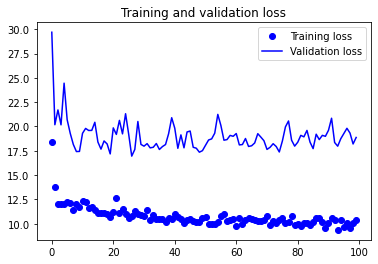

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()